# Continuous Control Project

---

[//]: # (Image References)

[image1]: https://user-images.githubusercontent.com/10624937/43851024-320ba930-9aff-11e8-8493-ee547c6af349.gif "Trained Agent"

This notebook descripts the results of the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). In this project, we train a set of agents to control a set of double-jointed arms in the Unity environment [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment.

![Trained Agent][image1]

A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of each agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

For this project, we use a Unity environment with 20 identical agents, each with its own copy of the environment.

The agents attempt to get an average score of +30 (over 100 consecutive episodes, and over all agents).  Specifically,
- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent.  This yields 20 (potentially different) scores.  We then take the average of these 20 scores.
- This yields an **average score** for each episode (where the average is over all 20 agents).

The environment is considered solved, when the average (over 100 episodes) of those average scores is at least +30.

The `README.md` file has information on how to setup the environement.

### Reinforcement Learning Approach

Throughout the following analysis, we build upon the approach of [Deep Deterministic Policy Gradients](https://arxiv.org/abs/1509.02971) (DDPQ).  At core of the DDPG algorithm are two functions: the actor, $\mu(s)$, and the critic, $Q(s,a)$.
The parameterized actor function $\mu(s;\theta_\mu)$ specifies the current policy by deterministically mapping states to a specific action.
The parameterized critic $Q(s, a;\theta_Q)$ is learned using the Bellman equation as in Q-learning. 

We represent the critic using a neutral network $Q(s,a;\theta^{Q\ell})$ that is trained to minimize $\mathbb{E}[(y_i - Q(s,a; \theta_i^{Q\ell}))^2]$ where 

$$y_i=\mathbb{E}[r_i + \gamma Q(s',\mu(s';\theta_i^{\mu t}); \theta^{Qt}_i)|s,a]$$

is known as the target and $\theta^{Qt}_i$ defined the parameters of the target network.
We represent the actor using a neutral network $\mu(s;\theta_i^{\mu \ell})$ that is trained to minimize $-\mathbb{E}[Q(s,\mu(s;\theta_i^{\mu \ell}); \theta_i^{Q\ell}]$.

The target parameters evolve from the local network parameters according to 
$$\theta^t_{i+1} \gets \tau \theta^\ell_{i+1} + (1-\tau)\theta^t_{i}.$$


For the networks used in this analysis, the sequential architecture is as follows for the actors

Input Size | Output Size | Activation
---------- | ----------- | ----------
state size | fc1_units | relu or leaky relu
fc1_units | fc2_units | relu or leaky relu
fc2_units | action size | tanh

For the critics, the architecture is as follows:

Input Size | Output Size | Activation
---------- | ----------- | ----------
state size | fsc1_units | relu or leaky relu
fsc1_units + action size | fc2_units | relu or leaky relu
fc2_units | 1 | none

### Analysis

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import os
from config import Config

%matplotlib inline

We experiment first on the hyperparameters related to layer size: `fc1_units`, `fsc1_units`, and `fc2_units`:

| fc1_units | fsc1_units | fc2_units
--- | --- | ---
400 | 400 | 300
200 | 200 | 150
100 | 100 | 75

Next, for each internal layer, we consider ReLU or LazyReLU for the activation function.

Finally, we consider batch sizes of 128 or 256.

In [79]:
experiments = [
    'ddpg-400-300',
    'ddpg-200-150',
    'ddpg-100-75',
    'ddpg-200-150-leaky',
    'ddpg-200-150-leaky-bs-256'
]

def load_experiment(name):
    return pd.read_csv(
        os.path.join('./saved-models',name,'results.csv'),
        header=None,
        names=['episode',name],
        index_col=0)

df = pd.concat(map(load_experiment, experiments), axis=1)

df.head()

,ddpg-400-300,ddpg-200-150,ddpg-100-75,ddpg-200-150-leaky,ddpg-200-150-leaky-bs-256
episode,,,,,
0,0.6020,0.5905,0.1385,0.8840,0.861
1,0.7315,0.9175,0.1435,1.1900,1.075
2,0.9060,0.9160,0.0700,1.0030,0.719
3,0.5060,0.8720,0.0130,1.0235,1.138
4,0.5735,0.9135,0.0075,0.2710,1.482


For each experiment configuration, we ran the agent for 1,000 episodes and recorded the scores.  The evolution of the score of each configuration as well as the rolling scores are shown the charts below.

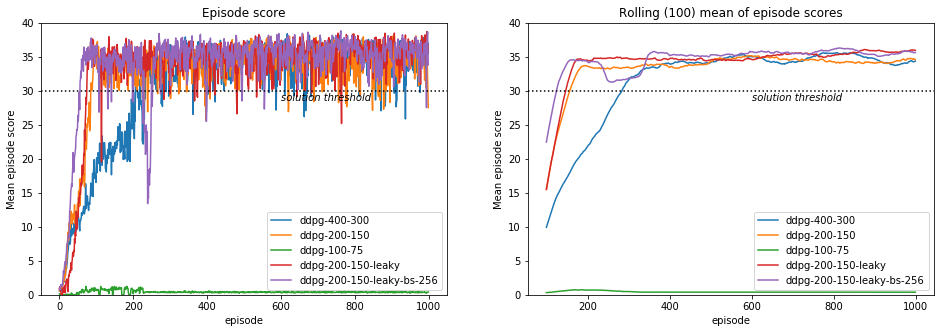

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax = df.plot(title='Episode score',ax=axes[0], ylim=(0,40));
ax.set_ylabel("Mean episode score");
ax.text(600, 28.5, 'solution threshold', style='italic');
ax.axhline(y=30, color='k', linestyle=':');
ax = df.rolling(100).mean().plot(title='Rolling (100) mean of episode scores',ax=axes[1], ylim=(0,40));
ax.set_ylabel("Mean episode score");
ax.text(600, 28.5, 'solution threshold', style='italic');
ax.axhline(y=30, color='k', linestyle=':');

We can see that all agents, with the exception of `ddpg-100-75`, exceed the solution threshold at some time during their evaluation and that `ddpg-200-150-leaky-bs-256` solves the environment first in the samples.

In [99]:
for experiment in experiments:
    solved_index = df[experiment].rolling(100).mean().where(lambda x: x>=30).dropna().index.min()
    if not np.isnan(solved_index):
        print('Solved in {1} episodes by {0}.'.format(experiment, solved_index))
    else:
        print('Not solved by {}.'.format(experiment))

Solved in 283 episodes by ddpg-400-300.
Solved in 156 episodes by ddpg-200-150.
Not solved by ddpg-100-75.
Solved in 146 episodes by ddpg-200-150-leaky.
Solved in 124 episodes by ddpg-200-150-leaky-bs-256.


### Closing notes and future work

DDQN performed well on this task, solving the environment within 125 episodes.  Using half the published layer sizes, among the tested sizes, performed best.  Leaky RELU performed slightly better than ReLU.  Larger batch sizes (of the two tested) performed better.  To confirm that these results are significant, more samples should be taken.

These results seem to hint that we could slightly improve results with more exploration in the initial episodes by increasing $\sigma$ in the Ornstein–Uhlenbeck process.

Clipping the 